### Thinkful exercise 3.2.6 - Challenge. Compare single decision tree to random forest using runtime

#### My objective: Learn to run and interpret decision tree and random forest regressors. The Thinkful example predicted the value of a categorical variable -- loan status -- not a continuous numeric value, such as diamond price in my project.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Source of dataset: Kaggle "Diamonds" https://www.kaggle.com/shivam2503/diamonds

#### Resources 

Timing a cell in a Jupyter notebook - https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

Decision tree regressor example - https://stackabuse.com/decision-trees-in-python-with-scikit-learn/

Random forest regressor example 1 - https://www.kaggle.com/dfitzgerald3/randomforestregressor


Random forest regressor example 2 - https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

The Kaggle kernel by Chimnay Rane (https://www.kaggle.com/fuzzywizard/diamonds-in-depth-analysis) goes through multiple model comparisons and was the source of some of my material (such as his method of reporting results).

My own notebook with EDA of the diamonds dataset is called "3_1_4_model_comparison".

In [2]:
diamonds = pd.read_csv('../../Datafiles/unit_3/diamonds.csv')

In [3]:
#Drop the column Unnamed; it has no use
diamonds = diamonds.drop(columns = 'Unnamed: 0', axis = 1)

In [4]:
#Rename some columns for clarity
diamonds = diamonds.rename(columns = {'x':'length_mm', 'y':'width_mm', 'z':'depth_mm', 'depth':'depth_pcnt'})

In [5]:
#Confirming there are no null values present
diamonds.isnull().values.any()

False

In [6]:
#Drop 20 rows with illogical values (non-zero table or width percentage; )
diamonds = diamonds[(diamonds[['width_mm', 'length_mm', 'depth_mm']] != 0).all(axis=1)]

In [7]:
#Reduce the number of features by creating a single volume feature
diamonds['vol_mm'] = diamonds.width_mm * diamonds.length_mm * diamonds.depth_mm
diamonds = diamonds.drop(columns = {'width_mm', 'length_mm', 'depth_mm'}, axis = 1)

In [8]:
diamonds_encoded = pd.get_dummies(data=diamonds)

In [9]:
diamonds_target = diamonds['price']
diamonds_features = diamonds_encoded.drop(columns = 'price', axis = 1 )

In [10]:
#Describing the price (target variable)
diamonds_target.describe()

count    53920.000000
mean      3930.993231
std       3987.280446
min        326.000000
25%        949.000000
50%       2401.000000
75%       5323.250000
max      18823.000000
Name: price, dtype: float64

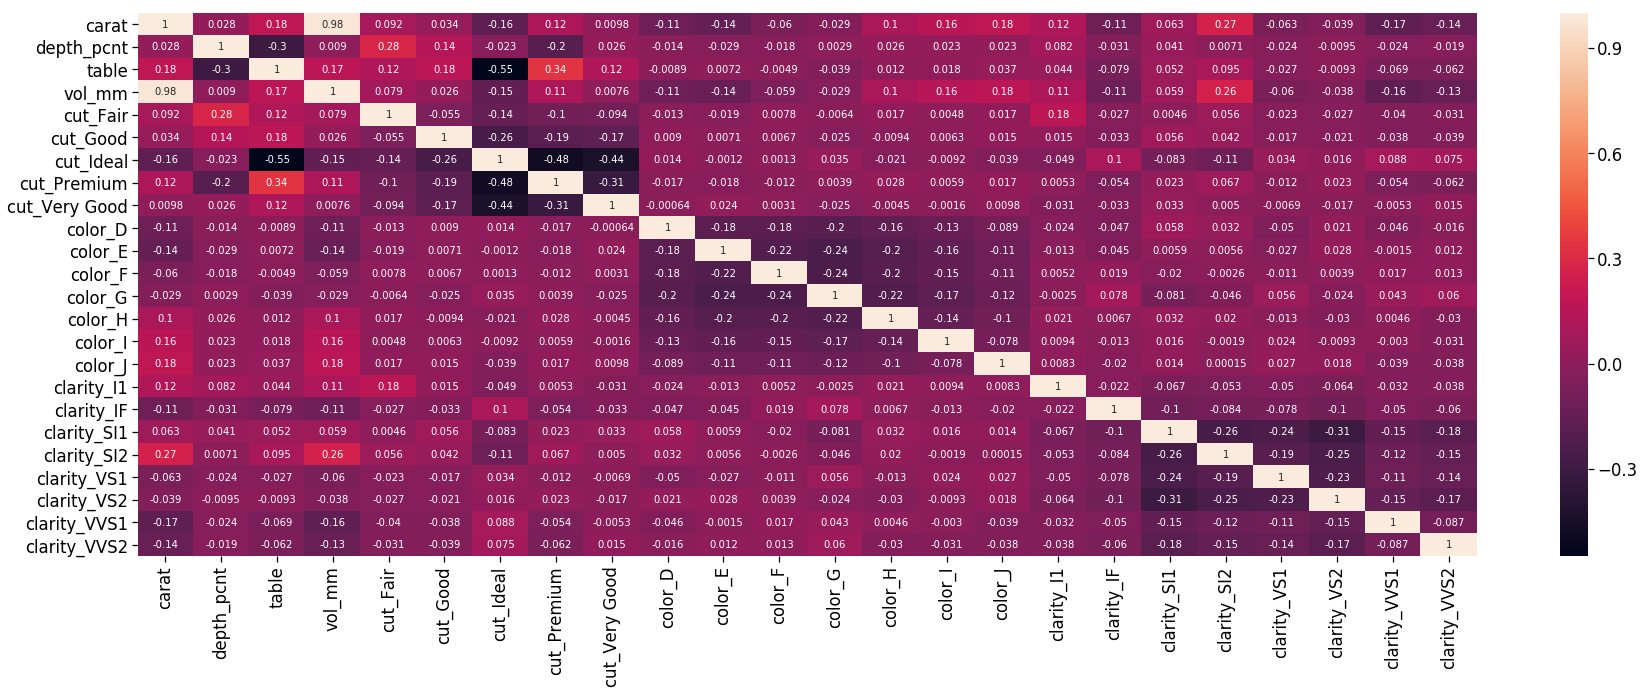

In [11]:
#Correlation between variables
plt.rcParams['figure.figsize'] = (30.0, 10.0)
features_corr = diamonds_features.corr()
sns.heatmap(data=features_corr, annot=True)

In [12]:
# Volume is highly correlated to carat weight, as we would suspect. Drop volume
diamonds_features = diamonds_features.drop(columns = 'vol_mm', axis = 1 )

In [13]:
#Do train-test split
X = diamonds_features
y = diamonds_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 8)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(43136, 23) (43136,)
(10784, 23) (10784,)


In [14]:
#Scale the numeric features. Note that we use transform method only on the test data (don't fit to test data)
scaler = StandardScaler()

#Improvement: Loop over the data frame columns and populate a numeric columns list by testing the data type
num_cols = ['carat', 'depth_pcnt', 'table']

X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), index = X_train.index)
X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), index = X_test.index)

In [15]:
X_train = pd.concat([X_train, X_train_num], axis = 1)
X_test = pd.concat([X_test, X_test_num], axis = 1)

In [16]:
X_train.rename(columns={0:'carat_sc', 1:'depth_pcnt_sc', 2: 'table_sc'}, inplace=True)
X_test.rename(columns={0:'carat_sc', 1:'depth_pcnt_sc', 2: 'table_sc'}, inplace=True)

In [17]:
X_train.drop(columns = num_cols, inplace = True)
X_test.drop(columns = num_cols, inplace = True)

In [18]:
X_train.shape

(43136, 23)

In [19]:
#Check the remaining columns in the training data
X_train.columns

Index(['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
       'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2',
       'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2',
       'carat_sc', 'depth_pcnt_sc', 'table_sc'],
      dtype='object')

In [20]:
#Make sure columns in test data match those in training data
X_test.columns

Index(['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
       'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2',
       'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2',
       'carat_sc', 'depth_pcnt_sc', 'table_sc'],
      dtype='object')

#### Decision tree regressor

In [21]:
%%time
import time
for _ in range(1000):
    time.sleep(0.01) # sleep for 0.01 seconds
    
tree_regr = DecisionTreeRegressor(max_depth = 5)
tree_regr.fit(X_train, y_train)

cv_score = cross_val_score(tree_regr, X_train, y_train, cv=5)

y_pred = tree_regr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('Decision Tree Regressor')
print('')
print('Score : %.4f ' % tree_regr.score(X_test, y_test))
print('')
print(cv_score)
print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

Decision Tree Regressor

Score : 0.9102 

[ 0.91450948  0.91024742  0.91385025  0.90948333  0.91124719]

MSE    : 1425996.20 
MAE    : 660.61 
RMSE   : 1194.15 
R2     : 0.91 
CPU times: user 377 ms, sys: 43.1 ms, total: 420 ms
Wall time: 12 s


#### Random forest regressor

n_estimators is the number of trees in the forest; 100 is the default. Here is one source for determining setting of max_features:
https://stackoverflow.com/questions/23939750/understanding-max-features-parameter-in-randomforestregressor
n_features = 'auto' means use all features, which is what I will do here, in order to compare to the decision tree and to the parameters used by Rane.

In [22]:
%%time
import time
for _ in range(1000):
    time.sleep(0.01) # sleep for 0.01 seconds

n_estimators = 100
n_features = round(X_train.shape[1] / 3)
    
forest_regr = RandomForestRegressor(n_estimators=100, max_depth = 5, max_features = 'auto')
forest_regr.fit(X_train, y_train)
cv_score = cross_val_score(forest_regr, X_train, y_train, cv = 5)

print('Random Forest Regressor')
print('')
print('Score : %.4f' % forest_regr.score(X_test, y_test))
print(cv_score)

y_pred = forest_regr.predict(X_test)
feature_imp = forest_regr.feature_importances_
print(feature_imp)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

Random Forest Regressor

Score : 0.9175
[ 0.92066222  0.91728659  0.92148814  0.91650278  0.91850768]
[  8.28928719e-06   0.00000000e+00   2.66240478e-04   0.00000000e+00
   0.00000000e+00   1.34563837e-04   3.22621653e-07   0.00000000e+00
   5.48372210e-06   1.62370435e-06   2.90369400e-07   4.39959404e-03
   1.41250133e-02   4.98147529e-04   1.06620724e-02   2.03553698e-02
   0.00000000e+00   0.00000000e+00   7.59427062e-04   2.12262340e-03
   9.46649734e-01   1.04133937e-05   7.90778694e-07]

MSE    : 1309377.99 
MAE    : 637.54 
RMSE   : 1144.28 
R2     : 0.92 
CPU times: user 18.1 s, sys: 114 ms, total: 18.2 s
Wall time: 29.8 s


### Discussion

Runtime analysis: In one test, a single decision tree ran 820 ms, while a random forest with 100 estimators ran 12.3 s (12,300 ms). The random forest model took about 15 times longer than the single decision tree. There must be some constant overhead, because the random forest with 100 estimators did not take 100 times as long as a single decision tree.

When I added max_features = 'auto' to the random forest regressor, it's runtime increased to 18.2 (though memory usage on my machine was different than the first run). The random forest took 23 times as much time to run as a single decision tree.

The random forest regressor performed best among the models used in the Kaggle kernel by Rane that I used for reference. The random forest regressor score using 5 folds was 0.9820. My scores are around 0.92. Why didn't my model perform as well?

Other examples that I referred to (including Rane's Kaggle kernel) used Grid Search to choose the estimators and the number of nodes to traverse (depth). Would this make a difference in my results? The purpose of Grid Search is to loop through and test the values of different model parameters, to see where performance is best.

What would happen if I dropped (or somehow normalized) the larger stones that skew the data? 

Should I re-state the price (target) as per carat? If I did that and then dropped the carat weight feature, I would be examining the question what factors other than size influence the price of a diamond, and be able to see how is each feature is weighted when carat weight is absent. This wouldn't conform to the read world marketing of diamonds, however.